In [246]:
import numpy as np
import random 

In [247]:
# ----------------------------
# 0) Utilities
# ----------------------------
def _rng(seed):
    return np.random.default_rng(seed)

def pad_to_pmax(a_time_p, p_max):
    """Pad [T, p_true] -> [T, p_max] with zeros."""
    T, p = a_time_p.shape
    out = np.zeros((T, p_max), dtype=a_time_p.dtype)
    out[:, :p] = a_time_p
    return out

def enforce_l1_stability(a_time, l1_cap=0.95, eps=1e-12):
    """
    Simple, robust stability-ish heuristic for AR:
      scale coefficients at each time t so sum_k |a_k(t)| <= l1_cap
    This is sufficient to prevent most explosions for benchmarking.
    """
    l1 = np.sum(np.abs(a_time), axis=1, keepdims=True)
    scale = np.minimum(1.0, l1_cap / (l1 + eps))
    return a_time * scale

In [248]:
# ----------------------------
# 1) Smooth coefficient schedules (Task 1)
# Each returns a_time with shape [T, p_true]
# ----------------------------

def schedule_sinusoid(T, p, rng, freq_range=(1/200, 1/100), amp_range=(0.05, 0.5)):
    t = np.arange(T)
    freqs  = rng.uniform(freq_range[0], freq_range[1], size=p)
    phases = rng.uniform(0, 2*np.pi, size=p)
    amps   = rng.uniform(amp_range[0], amp_range[1], size=p)
    a = np.zeros((T, p), dtype=np.float32)
    for k in range(p):
        a[:, k] = amps[k] * np.sin(2*np.pi*freqs[k]*t + phases[k])
    return a

def schedule_fourier(T, p, rng, M=3, base_freq_range=(1/900, 1/250), amp_scale=0.18):
    t = np.arange(T)
    base_f = rng.uniform(base_freq_range[0], base_freq_range[1], size=p)
    a = np.zeros((T, p), dtype=np.float32)
    for k in range(p):
        # Random harmonic amplitudes decay with m
        for m in range(1, M+1):
            A = rng.normal(0, amp_scale/(m**1.2))
            phi = rng.uniform(0, 2*np.pi)
            a[:, k] += A * np.sin(2*np.pi*(m*base_f[k])*t + phi)
    return a

def schedule_quasiperiodic(T, p, rng, f1_range=(1/900, 1/300), f2_range=(1/700, 1/250), amp_range=(0.05, 0.18)):
    t = np.arange(T)
    f1 = rng.uniform(f1_range[0], f1_range[1], size=p)
    f2 = rng.uniform(f2_range[0], f2_range[1], size=p)
    A1 = rng.uniform(amp_range[0], amp_range[1], size=p)
    A2 = rng.uniform(amp_range[0], amp_range[1], size=p)
    ph1 = rng.uniform(0, 2*np.pi, size=p)
    ph2 = rng.uniform(0, 2*np.pi, size=p)
    a = np.zeros((T, p), dtype=np.float32)
    for k in range(p):
        a[:, k] = A1[k]*np.sin(2*np.pi*f1[k]*t + ph1[k]) + A2[k]*np.sin(2*np.pi*f2[k]*t + ph2[k])
    return a

def schedule_polynomial_drift(T, p, rng, degree=5, coef_scale=0.15):
    # use normalized time in [-1, 1]
    tn = np.linspace(-1, 1, T)
    a = np.zeros((T, p), dtype=np.float32)
    for k in range(p):
        # small polynomial coefficients
        betas = rng.normal(0, coef_scale, size=degree+1)
        # a_k(t) = sum_d beta_d * tn^d
        ak = np.zeros(T)
        for d in range(degree+1):
            ak += betas[d] * (tn**d)
        a[:, k] = ak
    return a

def schedule_logistic_transition(T, p, rng, amp_range=(0.05, 0.25)):
    tau_range=(T/20, T/5)
    t = np.arange(T)
    a = np.zeros((T, p), dtype=np.float32)
    for k in range(p):
        alo = rng.uniform(-amp_range[1], amp_range[1])
        ahi = rng.uniform(-amp_range[1], amp_range[1])
        t0  = rng.integers(int(0.2*T), int(0.8*T))
        tau = rng.uniform(tau_range[0], tau_range[1])
        s = 1.0 / (1.0 + np.exp(-(t - t0)/tau))
        a[:, k] = alo + (ahi - alo) * s
    return a

def schedule_multi_sigmoid(T, p, rng, J=6, amp_step=0.12):
    tau_range=(T/50, T/12)
    t = np.arange(T)
    a = np.zeros((T, p), dtype=np.float32)
    for k in range(p):
        base = rng.uniform(-0.05, 0.05)
        ak = base * np.ones(T)
        # multiple smooth steps
        t0s = np.sort(rng.integers(int(0.1*T), int(0.9*T), size=J))
        for j in range(J):
            delta = rng.normal(0, amp_step)
            tau = rng.uniform(tau_range[0], tau_range[1])
            s = 1.0 / (1.0 + np.exp(-(t - t0s[j])/tau))
            ak += delta * s
        a[:, k] = ak
    return a

def schedule_gaussian_bumps(T, p, rng, J=8, amp_range=(0.05, 0.22)):
    width_range=(T/20, T/7)
    t = np.arange(T)
    a = np.zeros((T, p), dtype=np.float32)
    for k in range(p):
        base = rng.uniform(-0.03, 0.03)
        ak = base * np.ones(T)
        for _ in range(J):
            mu = rng.uniform(0.1*T, 0.9*T)
            sig = rng.uniform(width_range[0], width_range[1])
            c = rng.uniform(-amp_range[1], amp_range[1])
            ak += c * np.exp(-0.5 * ((t - mu)/sig)**2)
        a[:, k] = ak
    return a

def schedule_smooth_random(T, p, rng, amp=0.20):
    """
    GP-like smooth random function per lag (via Gaussian smoothing in frequency domain).
    Produces a very different, non-periodic but smooth class.
    """
    smooth_sigma=T/20 
    a = np.zeros((T, p), dtype=np.float32)
    # build Gaussian kernel in frequency domain for convolution
    freqs = np.fft.rfftfreq(T)
    # Gaussian smoothing kernel: exp(-2*pi^2*sigma^2*f^2)
    H = np.exp(-2*(np.pi**2) * (smooth_sigma**2) * (freqs**2))
    for k in range(p):
        w = rng.normal(0, 1, size=T)
        W = np.fft.rfft(w)
        sm = np.fft.irfft(W * H, n=T)
        sm = sm / (np.std(sm) + 1e-8)
        a[:, k] = (amp * sm).astype(np.float32)
    return a

# Registry of families you can benchmark
SCHEDULES = {
    "sinusoid": schedule_sinusoid,
    "fourier": schedule_fourier,
    "quasiperiodic": schedule_quasiperiodic,
    "poly_drift": schedule_polynomial_drift,
    "logistic": schedule_logistic_transition,
    "multi_sigmoid": schedule_multi_sigmoid,
    "gaussian_bumps": schedule_gaussian_bumps,
    "smooth_random": schedule_smooth_random,
}


In [249]:
# ----------------------------
# 2) Generic TVAR simulator (Task 1 core) with Power Reduction
# ----------------------------
def simulate_tvar(a_time, noise_std=0.3, seed=0, burn_in=10,
                  P0=0.5, W=40, decay_factor=0.98, power_control=True):
    """
    Simulate a TVAR process with optional power-constrained coefficient adaptation:
        x_t = a(t)^T [x_{t-1}, ..., x_{t-p}] + eps_t

    Args
    ----
    a_time : array, shape [T, p]
        Time-varying coefficients for each lag.
        a_time[t] = [a1(t), ..., ap(t)].
    noise_std : float
        Std dev of Gaussian innovations eps_t.
    seed : int
        RNG seed.
    burn_in : int
        Number of initial simulated samples to discard.
    P0 : float
        Target power threshold. If power exceeds this, coefficients are scaled down.
    W : int
        Window size for computing running power estimate.
    decay_factor : float
        Multiplicative decay applied to coefficients when power exceeds P0.
    power_control : bool
        If True, apply adaptive power reduction. If False, use original behavior.

    Returns
    -------
    x : array, shape [T]
        Simulated time series after discarding burn-in.
    a_out : array, shape [T, p]
        Actual (possibly adapted) coefficients used during simulation.
    """
    rng = _rng(seed)
    T, p = a_time.shape

    # Simulate a longer series, then drop the first burn_in samples
    T_full = T + int(burn_in)
    x_full = np.zeros(T_full, dtype=np.float32)
    eps = rng.normal(0.0, noise_std, size=T_full).astype(np.float32)

    # Track actual coefficients used (may differ from a_time due to power control)
    a_full = np.zeros((T_full, p), dtype=np.float32)

    # Initialize first p values
    x_full[:p] = eps[:p]

    # Current scale factor for power control (starts at 1.0)
    scale = 1.0

    # Main loop: for t >= p, use the same a_time indexing once we pass burn-in
    for t in range(p, T_full):
        # Map full-time index t -> coefficient index tau in [0, T-1]
        tau = t - int(burn_in)
        if tau < 0:
            # During burn-in: hold coefficients at the first value (a_time[0])
            a_t = a_time[0].copy()
        else:
            a_t = a_time[tau].copy()

        # Power control: check if recent power exceeds P0
        if power_control:
            window_start = max(0, t - W)
            if t - window_start > 0:
                current_power = np.mean(x_full[window_start:t]**2)
            else:
                current_power = 0.0

            # If power exceeds threshold, shrink scale
            if current_power > P0:
                scale = scale * decay_factor
            # Optionally allow scale to recover slowly when power is low
            elif current_power < P0 * 0.5 and scale < 1.0:
                scale = min(1.0, scale / decay_factor)

            a_t = a_t * scale

        # Store actual coefficients used
        a_full[t] = a_t

        lags = x_full[t-p:t][::-1]  # [x_{t-1},...,x_{t-p}]
        x_full[t] = float(np.dot(a_t, lags) + eps[t])

    # Drop burn-in
    x = x_full[int(burn_in):]
    a_out = a_full[int(burn_in):]
    
    return x, a_out

In [ ]:
# ----------------------------
# 3) One-sample generator + dataset wrapper (Task 2 groundwork)
# ----------------------------

def generate_one_tvar_sample(
    T=10_000,
    p_max=6,
    schedule_name="sinusoid",
    noise_std=0.3,
    seed=0,
    l1_cap=0.95,
    P0=0.5,
    W=40,
    decay_factor=0.98,
    power_control=True,
    p_true=True,  # If provided, use this p; otherwise random
    p_candidates=None,
):
    rng = _rng(seed)
    if p_candidates is None:
        p_candidates = np.array([2, 3, 4, 5, 6], dtype=int)
    
    # Use provided p_true or randomly select
    if p_true is None:
        p_true = int(rng.choice(p_candidates))
    else:
        p_true = int(p_true)

    # coefficient schedule for true p
    a_tp = SCHEDULES[schedule_name](T=T, p=p_true, rng=rng)
    a_tp = enforce_l1_stability(a_tp, l1_cap=l1_cap)

    # simulate signal with power control
    x, a_actual = simulate_tvar(
        a_tp, noise_std=noise_std, seed=seed+123,
        P0=P0, W=W, decay_factor=decay_factor, power_control=power_control
    )

    # pad coeffs to p_max for consistent storage
    a_t = pad_to_pmax(a_actual.astype(np.float32), p_max)

    meta = {
        "T": T,
        "p_max": p_max,
        "p_true": p_true,
        "schedule": schedule_name,
        "noise_std": float(noise_std),
        "seed": int(seed),
        "l1_cap": float(l1_cap),
        "P0": float(P0),
        "W": int(W),
        "decay_factor": float(decay_factor),
        "power_control": power_control,
        "p_candidates": list(p_candidates),
    }
    return x, a_t, meta

def generate_dataset(
    n_per_class=10,
    classes=None,
    T=1000,
    noise_range=(0.1, 0.6),
    seed=0,
    dtype=np.float32,
    P0=0.5,
    W=40,
    decay_factor=0.98,
    power_control=True,
    p_candidates=None,
    balanced_p=True,  # If True, balance samples across p_candidates
):
    
    p_max = 10
    
    if p_candidates is None:
        p_candidates = np.array([2, 3, 4, 5, 6], dtype=int)
    else:
        p_candidates = np.array(p_candidates, dtype=int)

    if classes is None:
        classes = list(SCHEDULES.keys())

    rng = _rng(seed)
    N = n_per_class * len(classes)

    X = np.zeros((N, T), dtype=dtype)
    A = np.zeros((N, T, p_max), dtype=dtype)
    p_true_arr = np.zeros((N,), dtype=np.int32)
    class_id = np.zeros((N,), dtype=np.int32)
    noise_std = np.zeros((N,), dtype=dtype)

    class_names = list(classes)
    
    # Precompute p assignments if balanced
    n_p = len(p_candidates)
    if balanced_p:
        n_per_p = n_per_class // n_p
        remainder = n_per_class % n_p
        # Create balanced p assignments for one class
        p_assignments = []
        for i, p in enumerate(p_candidates):
            count = n_per_p + (1 if i < remainder else 0)
            p_assignments.extend([p] * count)
    
    metas = []
    idx = 0
    for cid, cname in enumerate(class_names):
        # Shuffle p assignments for this class
        if balanced_p:
            class_p_assignments = rng.permutation(p_assignments)
        
        for i in range(n_per_class):
            s = int(rng.integers(0, 2**31 - 1))
            ns = float(rng.uniform(noise_range[0], noise_range[1]))
            
            # Determine p_true
            if balanced_p:
                p_true_val = int(class_p_assignments[i])
            else:
                p_true_val = None  # Let generate_one_tvar_sample pick randomly
            
            x, a_t, meta = generate_one_tvar_sample(
                T=T, p_max=p_max, schedule_name=cname, noise_std=ns, seed=s,
                P0=P0, W=W, decay_factor=decay_factor, power_control=power_control,
                p_true=p_true_val, p_candidates=p_candidates,
            )
            X[idx] = x.astype(dtype)
            A[idx] = a_t.astype(dtype)
            p_true_arr[idx] = meta["p_true"]
            class_id[idx] = cid
            noise_std[idx] = ns
            metas.append(meta)
            idx += 1

    dataset = {
        "X": X,
        "A": A,
        "p_true": p_true_arr,
        "class_id": class_id,
        "class_names": np.array(class_names),
        "noise_std": noise_std,
        "meta": metas,  # Python list of dicts; fine for notebook use
    }
    return dataset

def save_dataset_npz(path, dataset):
    # Save large arrays in npz; meta dicts as object array
    np.savez_compressed(
        path,
        X=dataset["X"],
        A=dataset["A"],
        p_true=dataset["p_true"],
        class_id=dataset["class_id"],
        class_names=dataset["class_names"],
        noise_std=dataset["noise_std"],
        meta=np.array(dataset["meta"], dtype=object),
    )

def load_dataset_npz(path):
    d = np.load(path, allow_pickle=True)
    return {
        "X": d["X"],
        "A": d["A"],
        "p_true": d["p_true"],
        "class_id": d["class_id"],
        "class_names": d["class_names"],
        "noise_std": d["noise_std"],
        "meta": list(d["meta"]),
    }

In [251]:
# ----------------------------
# 4) PINN Processor - load dataset for model training
# ----------------------------

def pinn_processor(npz_path, p_min=1):
    """
    Load a saved TVAR benchmark dataset and return arrays ready for training.
    
    Args
    ----
    npz_path : str
        Path to the .npz file saved by save_dataset_npz().
    p_min : int
        Minimum AR order used when generating the dataset. 
        Used to compute 0-indexed class labels for cross entropy.
    
    Returns
    -------
    X : array, shape [N, T]
        Time series samples.
    coeffs : array, shape [N, T, p_max]
        Time-varying AR coefficients (actual, after power control).
    p_true : array, shape [N]
        True AR order for each sample, 0-indexed (p_true_raw - p_min) for cross entropy.
    """
    dataset = load_dataset_npz(npz_path)
    
    X = dataset["X"]              # [N, T]
    coeffs = dataset["A"]         # [N, T, p_max]
    p_true_raw = dataset["p_true"]  # [N], actual AR orders (e.g., 1, 2, 4, 6)
    
    # Convert p_true to 0-indexed labels for cross entropy loss
    # Map unique p values to consecutive indices
    unique_p = np.sort(np.unique(p_true_raw))
    p_to_idx = {int(p): i for i, p in enumerate(unique_p)}
    p_true = np.array([p_to_idx[int(p)] for p in p_true_raw], dtype=np.int64)
    
    return X, coeffs, p_true



{'T': 1000, 'p_max': 20, 'p_true': 2, 'schedule': 'smooth_random', 'noise_std': 0.3, 'seed': 42, 'l1_cap': 0.95, 'P0': 0.5, 'W': 40, 'decay_factor': 0.98, 'power_control': True, 'p_candidates': [1, 2, 4, 6]}


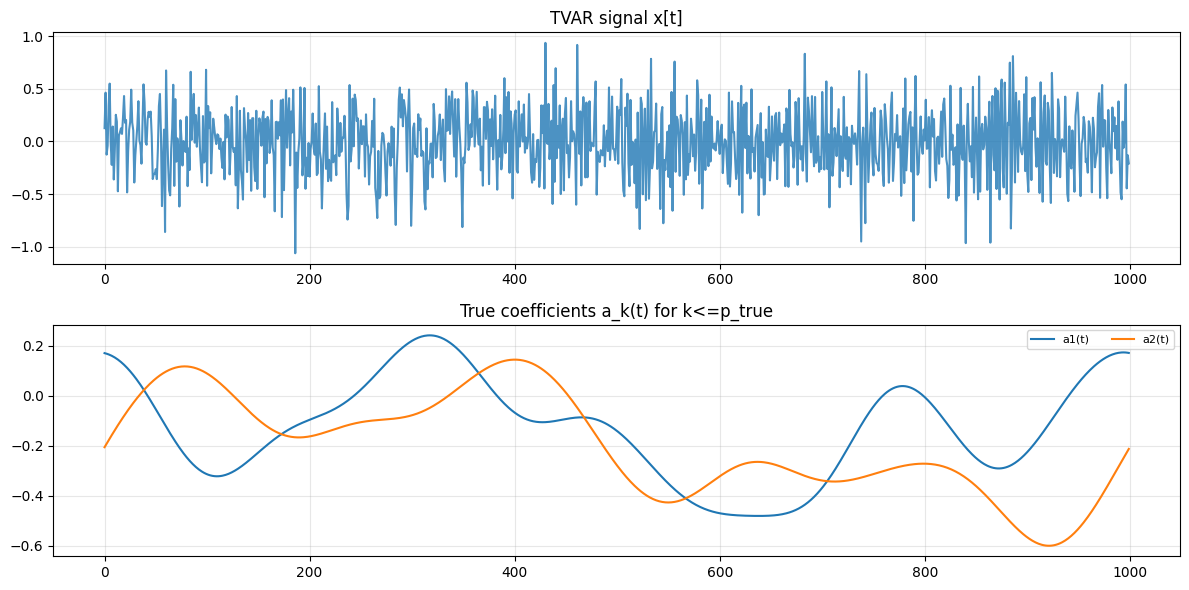

In [260]:
import matplotlib.pyplot as plt

T = 1000
p_max = 20

x, a_t, meta = generate_one_tvar_sample(
    T=T, p_max=p_max,
    schedule_name="smooth_random",
    noise_std=0.3,
    seed=42
)

print(meta)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(x, alpha=0.8)
plt.title("TVAR signal x[t]")
plt.grid(True, alpha=0.3)

plt.subplot(2,1,2)
p_true = meta["p_true"]
for k in range(p_true):
    plt.plot(a_t[:,k], label=f"a{k+1}(t)")
plt.title("True coefficients a_k(t) for k<=p_true")
plt.legend(ncol=4, fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [262]:
# # 8 families
# classes = list(SCHEDULES.keys())

# # small pilot: 10 per family => 80 samples total
# pilot = generate_dataset(
#     n_per_class=10000,
#     classes=classes,
#     T=600,
#     noise_range=(0.2, 0.5),
#     seed=123,
#     dtype=np.float32
# )

# print("X:", pilot["X"].shape, "A:", pilot["A"].shape)
# print("class_names:", pilot["class_names"])
# print("p_true distribution:", np.unique(pilot["p_true"], return_counts=True))

In [255]:
# save_dataset_npz("novak_data_final.npz", pilot)